# <center>GIVE ME SOME CREDIT (SKLEARN)</center>
<div style="text-align: right">Tous droits réservés © Nicolas SEVERINO</div>

In [68]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
train_full_df = pd.read_csv('./datasets/cs-training.csv')
test_df = pd.read_csv('./datasets/cs-test.csv')
dataframes = [train_full_df, test_df]
for df in dataframes:
    df.columns.values[0] = "Id"
    df.fillna(0, inplace=True)
    df['NumberOfTimes30DaysOrMoreLate'] = df['NumberOfTime30-59DaysPastDueNotWorse']+df['NumberOfTime60-89DaysPastDueNotWorse']+df['NumberOfTimes90DaysLate']
    df['IncomePerPerson'] = df['MonthlyIncome']/(df['NumberOfDependents']+1)
    df['MonthlyDebt'] = (
        np.where(
            df['DebtRatio']>=5,
            df['DebtRatio'],
            df['DebtRatio']*df['MonthlyIncome'],))
    df['MonthlyBalance'] = df['MonthlyIncome']-df['MonthlyDebt']

In [4]:
SEED = 42
np.random.seed(SEED)
from sklearn.model_selection import train_test_split
VAL_SIZE = 0.2
train_df, val_df = train_test_split(train_full_df, test_size = VAL_SIZE)

In [1]:
target_column = "SeriousDlqin2yrs"
y_train = train_df[target_column].values
X_train = train_df.drop(columns=target_column).values
y_val = val_df[target_column].values
X_val = val_df.drop(columns=target_column).values

NameError: name 'train_df' is not defined

In [38]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [59]:
#model = RandomForestClassifier()
model = XGBClassifier()

In [60]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [61]:
y_val_proba = model.predict_proba(X_val)[:,1]
print(y_val_proba[30:40])

[0.05607877 0.01226119 0.00864124 0.46317276 0.00570705 0.12622419
 0.10351232 0.01492614 0.01155602 0.01514034]


In [77]:
def set_prediction(threshold):
    return [1 if p> threshold else 0 for p in y_val_proba]

def count_error(y_val, y_val_pred):
    error = []
    for r, p in zip(y_val, y_val_pred):
        if (p == 1 and p == r): error.append('TP')
        if (p == 1 and p != r): error.append('FP')
        if (p == 0 and p == r): error.append('TN')
        if (p == 0 and p != r): error.append('FN')
    TP = error.count('TP')
    FP = error.count('FP')
    TN = error.count('TN')
    FN = error.count('FN')
    return TN, FP, FN, TP

In [2]:
threshold = 0.5
y_val_pred = set_prediction(threshold)
TN, FP, FN, TP = count_error(y_val, y_val_pred)
confusion_matrix = [[TN,FP],[FN,TP]]
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df
#print(f"{y_val_pred.count(1)} {y_val_pred.count(0)} {y_val_pred.count(1)+y_val_pred.count(0)}")

NameError: name 'set_prediction' is not defined

In [79]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_val_proba)

0.863150677404686

In [91]:
def tpr_fpr_lists(nb_thresholds):
    TPR, FPR = [], []
    for i in range(nb_thresholds+1):
        threshold = i/nb_thresholds
        pred = set_prediction(threshold)
        TN, FP, FN, TP = count_error(y_val, pred)
        TPR.append(TP/(TP+FN))
        FPR.append(FP/(FP+TN))
    return TPR, FPR

TPR, FPR = tpr_fpr_lists(50)

In [85]:
from sklearn.metrics import roc_curve
FPR, TPR, thresholds = roc_curve(y_val, y_val_proba)

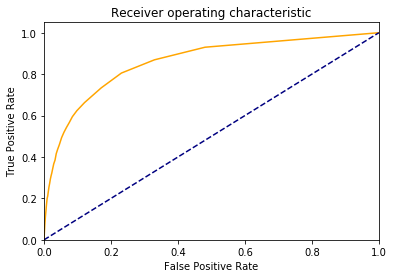

In [92]:
plt.plot(FPR,TPR,color='orange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [128]:
threshold = 0.5

y_test = test_df[target_column].values
X_test = test_df.drop(columns=target_column).values

y_test_proba = model.predict_proba(X_test)[:,1]

Id = [int(X_test[i][0]) for i in range(len(X_test))]
d = {'Id': Id, 'Probability': y_test_proba}
kaggle_df = pd.DataFrame(data=d)
kaggle_df

,Id,Probability
0,1,0.066369
1,2,0.038133
2,3,0.014904
3,4,0.081027
4,5,0.091048
...,...,...
101498,101499,0.027847
101499,101500,0.431968
101500,101501,0.006432
101501,101502,0.097106


In [130]:
kaggle_df.to_csv('./results/kaggle_sub.csv', index=False)

In [131]:
import kaggle
kaggle.api.competition_submit("./results/kaggle_sub.csv", "XGBClassifier", "GiveMeSomeCredit")

100%|██████████| 1.70M/1.70M [00:03<00:00, 536kB/s] 


Successfully submitted to Give Me Some Credit